In [74]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [28]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import matplotlib.pyplot as plt
plt.rc('font', family='Hancom Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 체크 및 전처리

In [78]:
# df_2021 = pd.read_csv('따릉이정보(25년은예측값활용필요)/2021년도따릉이대여이력대여일시행정구.csv',parse_dates=['연-월-일-시'])
# df_2021

# df_2021['연'] = df_2021['연-월-일-시'].dt.year
# df_2021['월'] = df_2021['연-월-일-시'].dt.month
# df_2021['일'] = df_2021['연-월-일-시'].dt.day
# df_2021['시'] = df_2021['연-월-일-시'].dt.hour
# # df_2021['요일'] = df_2021['연-월-일-시'].dt.dayofweek  # 월=0, 일=6
# # df_2021['주말여부'] = 1 if df_2021['연-월-일-시'].dt.dayofweek >= 5 else 0  # 예: Monday
# df_2021['일시'] = df_2021['연-월-일-시']
# df_2021 = df_2021[['연','월','일','시','행정구','일시','count']]

# df_2021.columns = ['연도','월','일','시','행정구','일시','대여량']
df_2021.to_csv('따릉이정보_25년은예측값활용필요/2021년따릉이연도일월시대여소번호대여량.csv',index=False)

In [21]:
df_2022 = pd.read_csv('따릉이정보(25년은예측값활용필요)/2022년따릉이연도일월시대여소번호대여량.csv')
df_2022 = df_2022[ ['연도','월','일','시','행정구','일시','대여량']]
df_2023 = pd.read_csv('따릉이정보(25년은예측값활용필요)/2023년따릉이연도일월시대여소번호대여량.csv')
df_2023 = df_2023[ ['연도','월','일','시','행정구','일시','대여량']]
df_2024 = pd.read_csv('따릉이정보(25년은예측값활용필요)/2024년따릉이연도일월시대여소번호대여량.csv')
df_2024 = df_2024[ ['연도','월','일','시','행정구','일시','대여량']]

In [30]:
df_2022.shape, df_2023.shape, df_2024.shape, df_2021.shape
df_2022.columns, df_2023.columns, df_2024.columns, df_2021.columns

((218069, 7), (218786, 7), (219464, 7), (217971, 7))

# 시계열 분석_일시&데이터를 통해

In [40]:
df_total = pd.concat([df_2021.groupby('일시')['대여량'].sum('총대여량'),df_2022.groupby('일시')['대여량'].sum('총대여량'),
                      df_2023.groupby('일시')['대여량'].sum('총대여량'),df_2024.groupby('일시')['대여량'].sum('총대여량')],axis=0)
df_total = df_total.reset_index()

C:\Users\wjdwh\AppData\Local\Temp\ipykernel_31308\2209327154.py:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_total = df_total.reset_index()


In [42]:
df_total

,일시,대여량
0,2021-01-01 00:00:00,365
1,2021-01-01 01:00:00,318
2,2021-01-01 02:00:00,240
3,2021-01-01 03:00:00,181
4,2021-01-01 04:00:00,140
...,...,...
35058,2024-12-31 19:00:00,3623
35059,2024-12-31 20:00:00,2753
35060,2024-12-31 21:00:00,2388
35061,2024-12-31 22:00:00,2128


## plt.plot으로 체크하기

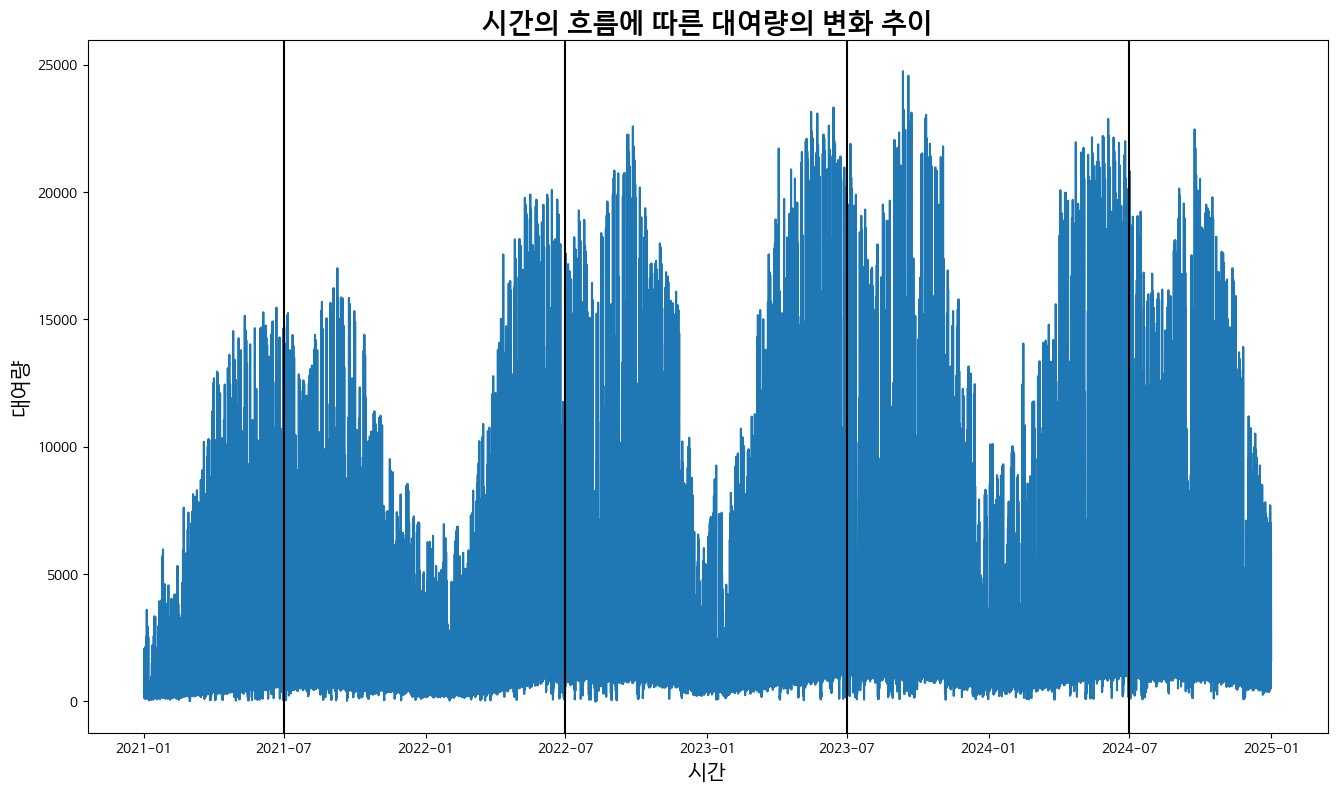

In [54]:
plt.figure(figsize=(16,9))
plt.plot(df_total['일시'], df_total['대여량'])
plt.axvline(x=pd.to_datetime('2021-07-01'), color='black')
plt.axvline(x=pd.to_datetime('2022-07-01'), color='black')
plt.axvline(x=pd.to_datetime('2023-07-01'), color='black')
plt.axvline(x=pd.to_datetime('2024-07-01'), color='black')
plt.xlabel('시간', size=15)
plt.ylabel('대여량', size=15)
plt.title('시간의 흐름에 따른 대여량의 변화 추이', size=20, fontweight='bold')
plt.show()

<font size=5>위 그림으로 보아 자전거는 월의 변화에 따른 트랜드가 발생하며 이는 기상, 계절과 연관성이 깊으므로 모델 설계의 feature로 사용</font>
- 한국의 경우, 계절별 기온, 풍속, 습도, 강수의 차이가 발생하므로 일시 데이터와 기상 데이터를 사용하여 계절성 고려 모델 생성

## statsmodel을 통한 트랜드 분석

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_total['대여량'],
                           model = 'additive',
                           period=90, 
                           )

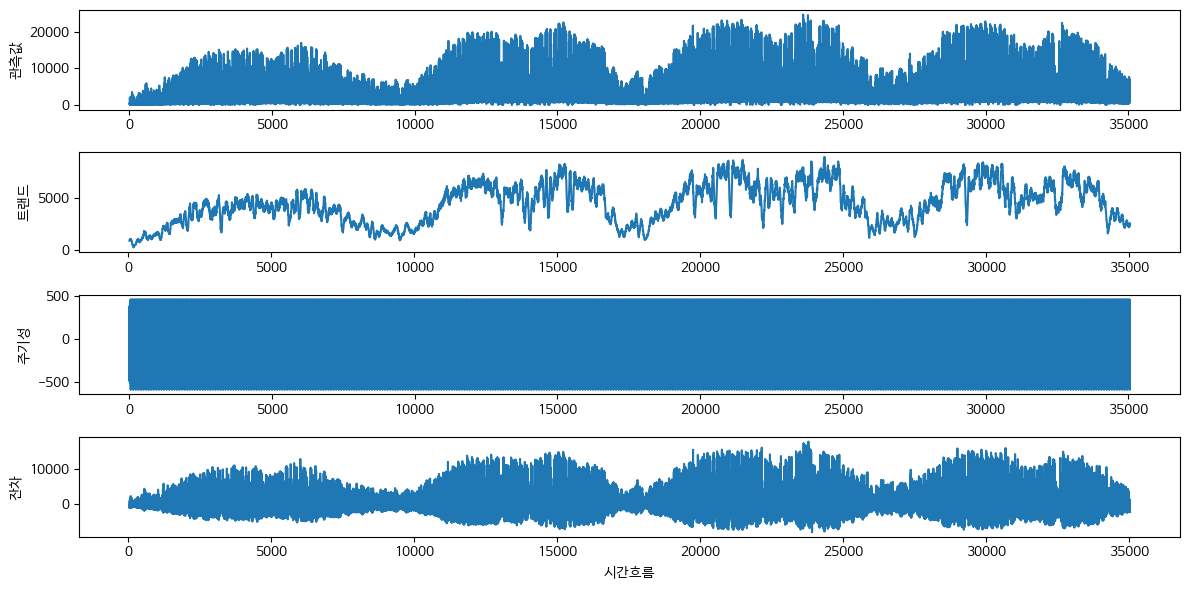

In [64]:
# 그래프로 체크
fig, axes = plt.subplots(4,1, figsize = (12,6))
axes[0].plot(result.observed)
axes[0].set_ylabel('관측값')
axes[1].plot(result.trend)
axes[1].set_ylabel('트랜드')
axes[2].plot(result.seasonal)
axes[2].set_ylabel('주기성')
axes[3].plot(result.resid)
axes[3].set_ylabel('잔차')
plt.xlabel('시간흐름')
plt.tight_layout()
plt.show()

# Prophet을 사용해서 예측하기

In [67]:
df_total_prophet = df_total
df_total_prophet.columns = ['ds','y']
df_total_prophet.head(2)

,ds,y
0,2021-01-01 00:00:00,365
1,2021-01-01 01:00:00,318


In [69]:
from prophet import Prophet
m = Prophet()
m.fit(df_total_prophet)

20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing


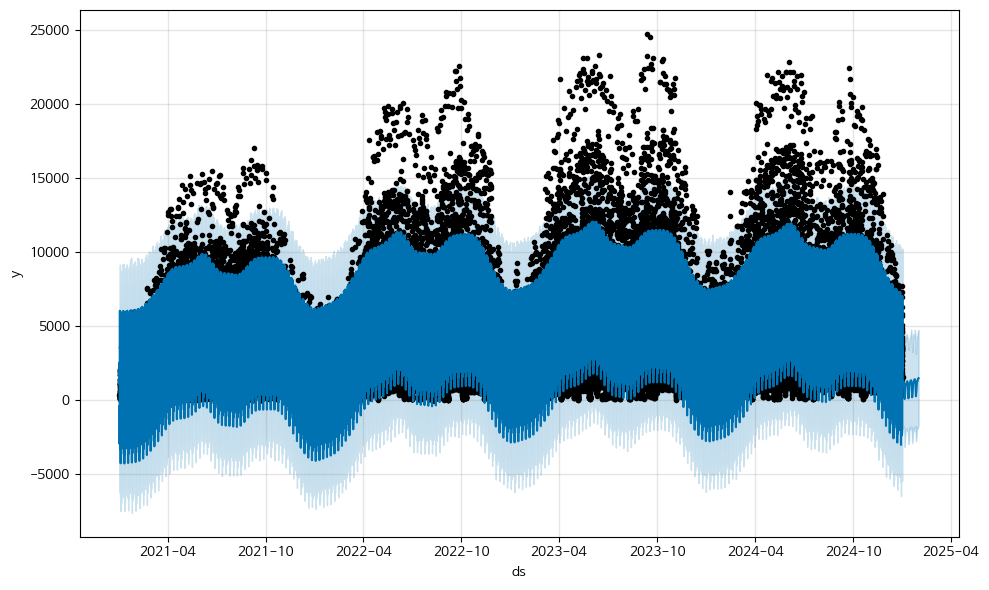

In [71]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
m.plot(forecast)
plt.show()

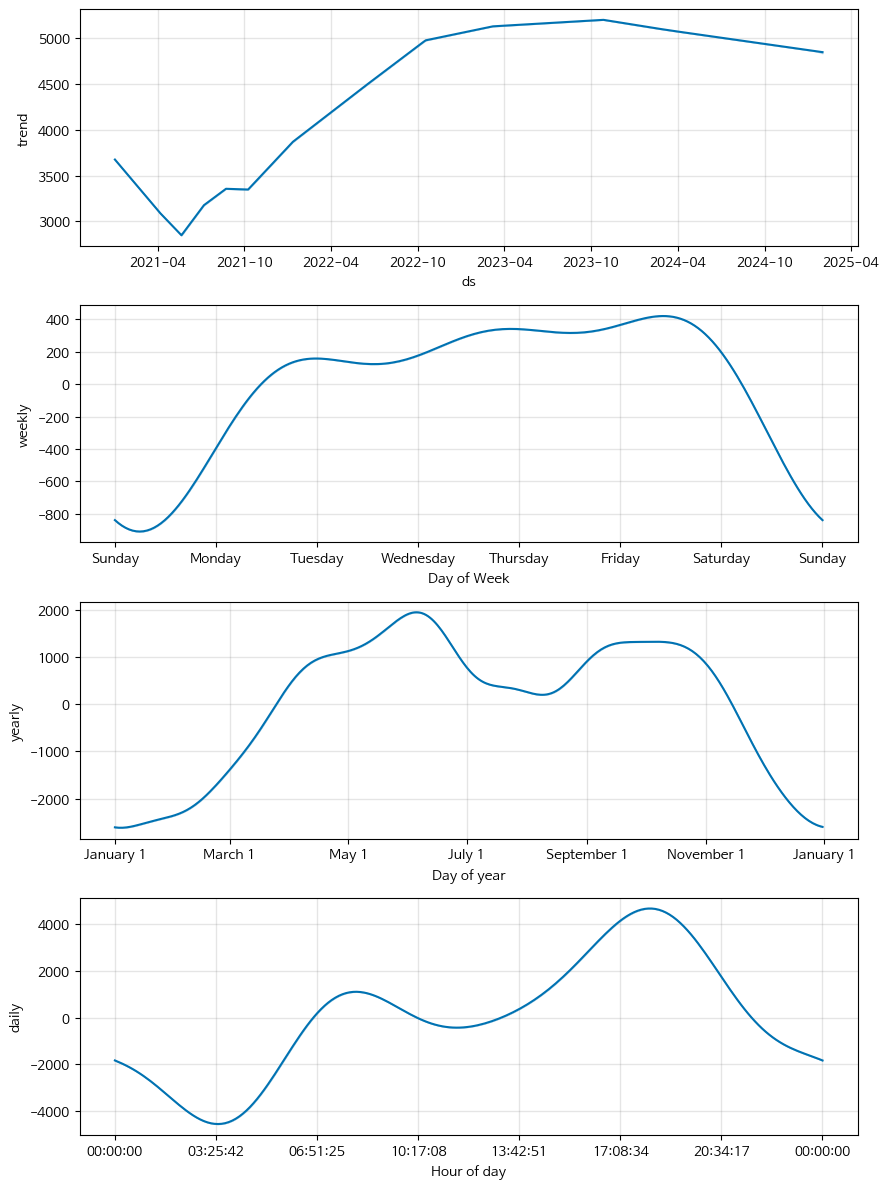

In [73]:
f2 = m.plot_components(forecast) # 트랜드와 휴일효과 그래프